In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
from torchtext import data
from torchtext import datasets
import collections
import math
import numpy as np

In [2]:
import re
import spacy
import string
from nltk.stem.porter import *
stemmer = PorterStemmer()
import nltk
from nltk.corpus import stopwords
stopword_lst = set(stopwords.words('english'))

nlp = spacy.load('en')
MAX_CHARS = 20000
def tokenizer(comment):
    comment = comment.lower()
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;#]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\,+", ",", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    return [x.text for x in nlp.tokenizer(comment) if x.text != " "]

def tfidftokenizer(comment):
    comment = comment.lower()
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;#.]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\,+", "", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    return [stemmer.stem(x.text) for x in nlp.tokenizer(comment) \
            if x.text != " " and x.text not in string.punctuation and x.text not in stopword_lst]

def segment_embedding(comment):
    comment = comment.lower()
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;#.]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\,+", "", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    word_lst = [stemmer.stem(x.text) for x in nlp.tokenizer(comment) \
            if x.text != " " and x.text not in string.punctuation and x.text not in stopword_lst]
    seg_embedding = np.zeros(200)
    for w in word_lst:
        if w in embedding.stoi:
            seg_embedding += np.array(embedding.vectors[embedding.stoi[w]])
    return seg_embedding/len(seg_embedding)

In [3]:
import csv
segs_lst = []
with open('data/csv/train/bags_and_cases.csv', 'r') as f:
    csvReader = csv.reader(f)
    next(csvReader)
    for line in csvReader:
        id_, rating, text, _ = line
        segs = text.split(" EDU_BREAK ")
        for s in segs:
            segs_lst.append(" ".join(tfidftokenizer(s)))
tmp = []
with open('data/gold/aspects/bags_and_cases-dev.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                segs_lst.append(" ".join(tfidftokenizer(text)))
            tmp = []
tmp = []   
with open('data/gold/aspects/bags_and_cases-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                segs_lst.append(" ".join(tfidftokenizer(text)))
            tmp = []


In [4]:
embedding = torchtext.vocab.Vectors('bags_and_cases.200d.txt')
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
class AspectNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        for param in self.embedding.parameters():
            param.requires_grad = False
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        
        logits = self.fc(cat)
        
        probs = F.softmax(logits, dim=1)
        
        classes = torch.max(logits, 1)[1]
            
        return probs, classes


In [6]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        for param in self.embedding.parameters():
            param.requires_grad = False
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        #self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        #self.apply(init_weights)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        
        #logits = self.fc(cat)
        
        #probs = F.softmax(logits, dim=1)
        
        #classes = torch.max(logits, 1)[1]
            
        #return probs, classes
        return cat

In [7]:
class CombineNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        
        self.cnn = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, 1, 
                 dropout, pad_idx)
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, 1)
        
        #self.fc2 = nn.Linear(64, 1)
        
        #self.apply(init_weights)
        
    def forward(self, text):
        
        cat = self.cnn(text)
        
        logits = self.fc1(cat)
        
        #logits = self.fc2(logits)
            
        polarity = torch.tanh(logits)
        
        return polarity

In [8]:
import json
 
with open('./model/aspect_label_vocab-bags-and-cases.json', 'r') as f:
    aspect_label_vocab = json.load(f)
    
with open('./model/aspect_text_vocab-bags-and-cases.json', 'r') as f:
    aspect_text_vocab = json.load(f)
    
with open('./model/sentiment_label_vocab-bags-and-cases.json', 'r') as f:
    sentiment_label_vocab = json.load(f)
    
with open('./model/sentiment_text_vocab-bags-and-cases.json', 'r') as f:
    sentiment_text_vocab = json.load(f)

In [9]:
aspect_label_vocab

['None',
 'Size_Fit',
 'Quality',
 'Looks',
 'Compartments',
 'Price',
 'Protection',
 'Customer_service',
 'Handles']

In [10]:
INPUT_DIM = len(aspect_text_vocab)
EMBEDDING_DIM = 200
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(aspect_label_vocab)
DROPOUT = 0.5

aspect_model = AspectNet(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, 1)
aspect_model = aspect_model.to(device)
aspect_model.load_state_dict(torch.load('./model/aspect-bags-and-cases.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
len(sentiment_text_vocab)

34286

In [12]:
INPUT_DIM = len(sentiment_text_vocab)
EMBEDDING_DIM = 200
N_FILTERS = 50
FILTER_SIZES = [2,3,4]
KOUTPUT_DIM = 2
DROPOUT = 0.5

senti_model = CombineNet(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, KOUTPUT_DIM, DROPOUT, 1)
senti_model = senti_model.to(device)
senti_model.load_state_dict(torch.load('./model/sentiment-bags-and-cases.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
def generate_aspect(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok for tok in tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = []
    for t in tokenized:
        if t in aspect_text_vocab:
            indexed.append(aspect_text_vocab[t])
        else:
            indexed.append(0)
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    probs, classes = model(tensor)
    return probs.squeeze(0).detach().cpu().numpy(), classes.squeeze(0).detach().cpu().numpy()
    
    
    
def generate_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok for tok in tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = []
    for t in tokenized:
        if t in sentiment_text_vocab:
            indexed.append(sentiment_text_vocab[t])
        else:
            indexed.append(0)
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    pols = model(tensor)
    return pols.item()


In [14]:
print(sentiment_label_vocab)

['negative', 'positive']


In [15]:
print(aspect_label_vocab)

['None', 'Size_Fit', 'Quality', 'Looks', 'Compartments', 'Price', 'Protection', 'Customer_service', 'Handles']


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(segs_lst)
sent_vectors = X.toarray()


In [17]:
def sent_to_vec(s):
    return sent_vectors[segs_lst.index(s)]

In [29]:
def generate_summary(doc):
    segments = doc.split(' EDU_BREAK ')
    tmp = []
    pols = []
    for i, seg in enumerate(segments):
        polarity = generate_sentiment(senti_model, seg)
        pols.append(polarity)
    scaled_pols = preprocessing.StandardScaler().fit_transform(np.array(pols).reshape(-1,1))
    
    for i, seg in enumerate(segments):
        probs1, classes1 = generate_aspect(aspect_model, seg)
        #print(seg)
        #print(probs1)
        #print(aspect_label_vocab[classes1])
        polarity = generate_sentiment(senti_model, seg)
        #print(probs2)
        #print(sentiment_label_vocab[classes2])
        #print()
        aspect_score = max(probs1[:]) - probs1[0]
        #if seg_aspect_map[seg] == "None":
            #aspect_score = 0
        #else:
            #aspect_score = 1
        senti_score = abs(polarity)
        #senti_score = abs(scaled_pols[i][0])
        if senti_score < 0.5:
            senti_score = 0
        if aspect_score*senti_score != 0:
            tmp.append((aspect_score*senti_score, seg, i, aspect_label_vocab[classes1]))
            #tmp.append((aspect_score*senti_score, seg, i, aspect_label_vocab[classes1]))
        
    res = sorted(tmp, key=lambda x: x[0], reverse=True)
    weights, sents, indices, aspects = map(list, zip(*res))
    summary = []
    
    from sklearn.metrics.pairwise import cosine_similarity
    asps = set()
    for s, asp in zip(sents, aspects):
        if asp in asps:
            continue
        included = False
        s1 = sent_to_vec(" ".join(tfidftokenizer(s))).reshape(1,-1)
        #s1 = segment_embedding(s).reshape(1,-1)
        for s_prime in summary:
            s2 = sent_to_vec(" ".join(tfidftokenizer(s_prime))).reshape(1,-1)
            #s2 = segment_embedding(s_prime).reshape(1,-1)
            cosine = cosine_similarity(s1, s2)[0][0]
            #print(cosine)
            if cosine > 0.5:
                included = True
                break
        if not included and asp != "None":
            summary.append(s)
            asps.add(asp)
    return summary

In [30]:
from collections import defaultdict
tmp = []
data = defaultdict(list)
with open('data/gold/aspects/bags_and_cases-dev.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                data[product_id].append(text)
            tmp = []
tmp = []   
with open('data/gold/aspects/bags_and_cases-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                data[product_id].append(text)
            tmp = []


In [31]:
data = list(map(lambda x: tuple([x[0], ' EDU_BREAK '.join(x[1])]), data.items()))

In [32]:
data

[('B0000A2QBX',
  "The photo online and on the card EDU_BREAK attached to the case shows foam. EDU_BREAK Where is it? EDU_BREAK I don't have any foam included. EDU_BREAK There is NO way this thin! thin! thin! case would protect a pencil let alone a heavy laptop. EDU_BREAK Don't waste your money. EDU_BREAK Mine goes back tomorrow! EDU_BREAK I use this case on a daily basis EDU_BREAK and have used it for about five months and by then both strap attachments EDU_BREAK and the handle broke EDU_BREAK and I am already having to look for a new case. EDU_BREAK If you are going to use this daily buy something that EDU_BREAK is of better quality. EDU_BREAK It looks nice EDU_BREAK and is not very bulky EDU_BREAK but will brake due to poor quality. EDU_BREAK I really liked this bag. EDU_BREAK It has room for power cables and a few other small things. EDU_BREAK I had it for over a year EDU_BREAK but only used it occasionally. EDU_BREAK Unfortunately over the holidays the hand strap broke. EDU_BREAK 

In [33]:
ref = []
with open('./data/gold/summaries/bags_and_cases/all/bags_and_cases.B0000A2QBX.B.all.txt', 'r') as f:
    for line in f:
        ref.append(line)


In [34]:
ref

['The quality of the bag is outstanding.\n',
 'The design is perfect to fit the laptop, batteries, pens, paperwork, etc..\n',
 'The padding inside really keeps the laptop secure.\n',
 'Nice looking, and well built.\n',
 'There is NO way this thin! thin! thin! case would protect a pencil let alone a heavy laptop.\n',
 'but will brake due to poor quality.']

In [35]:
len(data[0][1].split(" EDU_BREAK "))

121

In [36]:
tmp = []
seg_aspect_map = {}
with open('data/gold/aspects/bags_and_cases-dev.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspect_lst = aspect.strip().split()
                seg_aspect_map[text] = aspects[int(aspect_lst[0])]
            tmp = []
tmp = []   
with open('data/gold/aspects/bags_and_cases-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspect_lst = aspect.strip().split()
                seg_aspect_map[text] = aspects[int(aspect_lst[0])]
            tmp = []

In [37]:
aspects

['Compartments',
 'Customer_service',
 'Handles',
 'Looks',
 'None',
 'Price',
 'Protection',
 'Quality',
 'Size_Fit']

In [38]:
from sklearn import preprocessing

In [39]:
seg_aspect_map

{'The photo online and on the card': 'None',
 'attached to the case shows foam.': 'None',
 'Where is it?': 'None',
 "I don't have any foam included.": 'None',
 'There is NO way this thin! thin! thin! case would protect a pencil let alone a heavy laptop.': 'Protection',
 "Don't waste your money.": 'None',
 'Mine goes back tomorrow!': 'None',
 'I use this case on a daily basis': 'None',
 'and have used it for about five months and by then both strap attachments': 'Handles',
 'and the handle broke': 'Handles',
 'and I am already having to look for a new case.': 'None',
 'If you are going to use this daily buy something that': 'Quality',
 'is of better quality.': 'Quality',
 'It looks nice': 'Looks',
 'and is not very bulky': 'None',
 'but will brake due to poor quality.': 'Quality',
 'I really liked this bag.': 'None',
 'It has room for power cables and a few other small things.': 'Compartments',
 'I had it for over a year': 'None',
 'but only used it occasionally.': 'None',
 'Unfortunate

In [40]:
import seaborn as sns
pols_array = []
for d in data:
    prod_id, text = d
    print(prod_id)
    segments = text.split(' EDU_BREAK ')
    pols = []
    for i, s in enumerate(segments):
        pol = generate_sentiment(senti_model, s)
        pols.append(pol)
    pols_array.append(pols)

B0000A2QBX
B0009JR5K0
B000VB7EFW
B00307F8PW
B0038KLD50
B003BWYJ4C
B0064RDIWU
B0083LOW7A
B0085B772A
B009PJ2CQC


In [41]:
np.max(pols_array[0])

0.9707266092300415

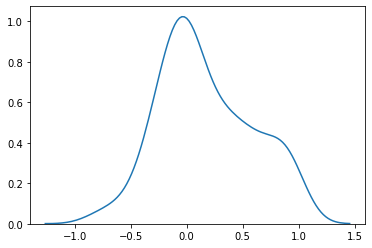

In [42]:
sns.kdeplot(pols_array[2])

In [48]:
from rouge import Rouge 
rouge = Rouge()
scores_1 = []
scores_2 = []
scores_l = []
for d in data:
    prod_id, text = d
    print(prod_id)
    print(text)
    print()
    segments = text.split(' EDU_BREAK ')
    for s in segments:
        probs1, classes1 = generate_aspect(aspect_model, s)
        aspect_score = max(probs1[:]) - probs1[0]
        polarity = generate_sentiment(senti_model, s)
        print((s, aspect_label_vocab[classes1], aspect_score, polarity))
    res = generate_summary(text)
    print()
    for s in res:
        probs1, classes1 = generate_aspect(aspect_model, s)
        aspect_score = max(probs1[:]) - probs1[0]
        print((s, seg_aspect_map[s], aspect_label_vocab[classes1], aspect_score))
    print()
    for s in res:
        polarity = generate_sentiment(senti_model, s)
        print((s, polarity))
    
    ref_B = []
    with open('./data/gold/summaries/bags_and_cases/all/bags_and_cases.'+ prod_id +'.B.all.txt', 'r') as f:
        for line in f:
            ref_B.append(line.rstrip())
    score_B = rouge.get_scores(' '.join(res), ' '.join(ref_B))[0]
    
    scores_1.append(score_B['rouge-1']['f'])
    scores_2.append(score_B['rouge-2']['f'])
    scores_l.append(score_B['rouge-l']['f'])
    
    ref_J = []
    with open('./data/gold/summaries/bags_and_cases/all/bags_and_cases.'+ prod_id +'.J.all.txt', 'r') as f:
        for line in f:
            ref_J.append(line.rstrip())
    score_J = rouge.get_scores(' '.join(res), ' '.join(ref_J))[0]
    scores_1.append(score_J['rouge-1']['f'])
    scores_2.append(score_J['rouge-2']['f'])
    scores_l.append(score_J['rouge-l']['f'])
    
    ref_M = []
    with open('./data/gold/summaries/bags_and_cases/all/bags_and_cases.'+ prod_id +'.M.all.txt', 'r') as f:
        for line in f:
            ref_M.append(line.rstrip())
    score_M = rouge.get_scores(' '.join(res), ' '.join(ref_M))[0]
    """
    print(text)
    print()
    print(res)
    print()
    print(ref_B)
    print()
    print(ref_J)
    print()
    print(ref_M)
    print()
    print()
    """
    scores_1.append(score_M['rouge-1']['f'])
    scores_2.append(score_M['rouge-2']['f'])
    scores_l.append(score_M['rouge-l']['f'])
    print()

B0000A2QBX
The photo online and on the card EDU_BREAK attached to the case shows foam. EDU_BREAK Where is it? EDU_BREAK I don't have any foam included. EDU_BREAK There is NO way this thin! thin! thin! case would protect a pencil let alone a heavy laptop. EDU_BREAK Don't waste your money. EDU_BREAK Mine goes back tomorrow! EDU_BREAK I use this case on a daily basis EDU_BREAK and have used it for about five months and by then both strap attachments EDU_BREAK and the handle broke EDU_BREAK and I am already having to look for a new case. EDU_BREAK If you are going to use this daily buy something that EDU_BREAK is of better quality. EDU_BREAK It looks nice EDU_BREAK and is not very bulky EDU_BREAK but will brake due to poor quality. EDU_BREAK I really liked this bag. EDU_BREAK It has room for power cables and a few other small things. EDU_BREAK I had it for over a year EDU_BREAK but only used it occasionally. EDU_BREAK Unfortunately over the holidays the hand strap broke. EDU_BREAK Great bu

('been looking for!', 'None', 0.0, 0.34618332982063293)
('I purchased this case', 'None', 0.0, 0.010111319832503796)
('because it looked very functional...', 'None', 0.0, 0.5609666109085083)
("To my surprise the rivets popped out and the zipper broke about two weeks into it's use.", 'Handles', 0.24945219, -0.8407869338989258)
('I have never been disappointed by a Sampsonite product until now.', 'Customer_service', 0.07399057, -0.8121441006660461)
('I have written to them', 'None', 0.0, -0.08041271567344666)
('and received no communication in return!', 'Customer_service', 0.92040044, -0.7573544383049011)
('I bought', 'None', 0.0, 0.049116868525743484)
('this case for Dell Inspiron E1505', 'Size_Fit', 0.7951103, 0.4713638722896576)
("(15. 4 '')", 'None', 0.0, -0.014712856151163578)
('screen.', 'None', 0.0, -0.06568121910095215)
('It was way too small.', 'Size_Fit', 0.09127724, -0.22914834320545197)
('This case has an inner pocket,', 'Compartments', 0.9944936, 0.4922262728214264)
('which 

('This bag is incredible', 'None', 0.0, 0.2922748327255249)
('if you have a 17 inch laptop.', 'Size_Fit', 0.8949506, 0.33472001552581787)
("It's so hard", 'None', 0.0, -0.11975184828042984)
('to find a good bag', 'None', 0.0, 0.6266928315162659)
("that'll fit my enormous laptop,", 'Size_Fit', 0.99822265, 0.34037721157073975)
('and this one more than fits the bill.', 'Size_Fit', 0.8826292, 0.8533802628517151)
('It has a really comfortable handle', 'Handles', 0.39601564, 0.8837951421737671)
('if you need', 'None', 0.0, 0.18334263563156128)
('to carry it,', 'Size_Fit', 0.08971459, 0.2906681299209595)
('and has so many hidden pockets', 'Compartments', 0.9481735, 0.5952396988868713)
('and places to put things.', 'None', 0.0, 0.08594643324613571)
('I love it,', 'None', 0.0, 0.8576421141624451)
("and can't say enough about it.", 'None', 0.0, 0.3191675841808319)
('The quality is also excellent.', 'Quality', 0.9711272, 0.908889889717102)
('I highly recommend getting one.', 'None', 0.0, 0.772622

('Granted,', 'None', 0.0, -0.009553821757435799)
('the bag holds it all very well with room to spare', 'Size_Fit', 0.9896152, 0.9768081307411194)
('and it is very durable.', 'Quality', 0.5458654, 0.850304126739502)
('I bought the bag a couple years ago', 'None', 0.0, 0.08319839835166931)
('and it still looks brand new.', 'None', 0.0, 0.5261023044586182)
("I've also used the bag for weekend camping", 'None', 0.0, 0.36313948035240173)
('(minus the laptop)', 'None', 0.0, 0.058685120195150375)
('and can fit all my clothes', 'Size_Fit', 0.9992241, 0.6142099499702454)
('and whatnot in it --', 'None', 0.0, 0.030707495287060738)
('I love', 'None', 0.0, 0.9246107935905457)
('how much', 'None', 0.0, 0.09686833620071411)
('stuff it can hold.', 'Size_Fit', 0.5890469, 0.56040358543396)
('Also,', 'None', 0.0, 0.12357790768146515)
('once I have the bag on my back,', 'None', 0.0, -0.06190430372953415)
('the straps are very comfortable.', 'Handles', 0.2574309, 0.9092841744422913)
("It's just not the li


('This is a very well made bag, nice construction, lots of pockets.', 'Quality', 'Compartments', 0.9963302)
('the bag holds it all very well with room to spare', 'None', 'Size_Fit', 0.9896152)
('this as a good price. that is all', 'Price', 'Price', 0.9702753)
('The quality is excellent', 'Quality', 'Quality', 0.9839237)
('to return Christmas gifts -', 'Customer_service', 'Customer_service', 0.94801205)
('and protects everything inside.', 'Protection', 'Protection', 0.7260869)
("and there's a connector there as well with the wire running down through the bag strap to a connector outside of the bag for you", 'Compartments', 'Handles', 0.87592125)
('not that it was difficult through Amazon', 'Customer_service', 'Looks', 0.10962205)

('This is a very well made bag, nice construction, lots of pockets.', 0.9800881147384644)
('the bag holds it all very well with room to spare', 0.9768081307411194)
('this as a good price. that is all', 0.8956615924835205)
('The quality is excellent', 0.856266

("and it's very spacious for my 15 '' laptop and other books, folders for school.", 'Size_Fit', 0.7537851, 0.8985211253166199)
('The ONLY complaint is', 'None', 0.0, 0.26177269220352173)
('that I wish', 'None', 0.0, 0.020466970279812813)
('it had small pockets on the outside for my phone, wallet, keys instead of one huge pocket', 'Compartments', 0.99963707, 0.702844500541687)
('where I find myself digging for those things.', 'None', 0.0, 0.11825691908597946)
('But that is just me complaining,', 'None', 0.0, -0.058934781700372696)
('because this is a really great buy.', 'None', 0.0, 0.8929426670074463)
('Crap.', 'None', 0.0, -0.18359410762786865)
('The " leather " is already peeling,', 'Quality', 0.5546433, -0.4189782738685608)
('and the straps are small..', 'Handles', 0.46430984, -0.0303751602768898)
('I can barely sling it over my shoulder.', 'Handles', 0.64853024, 0.38932710886001587)
('It will fit a lap top.. and that is about it.', 'Size_Fit', 0.99777275, -0.046394988894462585)
('H

("but for my purposes, I've got lots of room", 'Size_Fit', 0.7393986, 0.8729350566864014)
('to spare for other goodies', 'Size_Fit', 0.184, 0.5089036822319031)
("and that's the biggest reason", 'None', 0.0, -0.04581267014145851)
('I like it.', 'None', 0.0, 0.24651125073432922)
("As far as internal padding, it's a bit weak for my taste.", 'None', 0.0, 0.3625302314758301)
('I place my netbook inside a padded sleeve', 'None', 0.0, 0.7478392720222473)
('before placing it into this bag.', 'None', 0.0, -0.09003553539514542)
('I like a little more protection for my computer', 'Protection', 0.28546005, 0.7466790080070496)
('than what is in this bag.', 'None', 0.0, 0.14705131947994232)
("If I didn't already have a padded sleeve,", 'None', 0.0, 0.14863234758377075)
("I'd probably be disappointed with this bag.", 'None', 0.0, -0.5432202219963074)
("I'm also not sure how durable this material is.", 'Quality', 0.890865, 0.6600673198699951)
("I've been using this bag daily for well over a month now 

('I hope the handles wear well', 'Handles', 0.7009186, 0.2558715343475342)
('but I would feel this about any product', 'Looks', 0.016175434, -0.1619323343038559)
('made of the same material.', 'Quality', 0.6457011, -0.0987841933965683)
('The bag closes up very nice and is not baggie or sloppy looking,', 'None', 0.0, 0.866774320602417)
('it has good form,', 'None', 0.0, 0.8122599124908447)
("that's important to me.", 'None', 0.0, 0.09962861984968185)
('The function of the bag and its clean lines are well thought out.', 'None', 0.0, 0.8224849700927734)
('Over all a really good purchases.', 'None', 0.0, 0.8620439767837524)

('I was happy with this bag early on.. seemingly well padded, lots of space and pockets, and an attractive design for a reasonable price.', 'Price', 'Compartments', 0.9971271)
('and for the price it is a great value.', 'Price', 'Price', 0.94539654)
('and the laptop fits perfect there.', 'Size_Fit', 'Size_Fit', 0.8492512)
('that the vendor sent', 'None', 'Customer_servi

("It doesn't add much bulk to the super-thin MBAir", 'Protection', 0.037793383, 0.20608137547969818)
('and yet provides enough protection during normal use.', 'Protection', 0.6732915, 0.9189441204071045)
("It fits very nicely in my wife's purse", 'Size_Fit', 0.8110409, 0.977302610874176)
('and looks great!', 'None', 0.0, 0.9215877056121826)
('It was very small and tight.', 'Size_Fit', 0.18647018, 0.20747828483581543)
('I really did not like it.', 'None', 0.0, 0.010106897912919521)
('The pink flowers look really fake and cheap.', 'Looks', 0.9219383, -0.0825345516204834)
('I have a case on my 13 inch macbook and its very hard', 'Size_Fit', 0.8098815, 0.39454957842826843)
('to close it.', 'None', 0.0, -0.13941267132759094)
('When I got this case I got it', 'None', 0.0, -0.14351023733615875)
('because it said', 'None', 0.0, -0.04762295261025429)
('it would fit a 13-14 inch Notebook Laptop Computer.', 'Size_Fit', 0.9998881, 0.28493568301200867)
('I have a 14 inch', 'Size_Fit', 0.38556105, 0

('but I do', 'None', 0.0, -0.05244383215904236)
('it anyways', 'None', 0.0, -0.021421317011117935)
("and there aren't that many marks.", 'Protection', 0.049191922, 0.07264211773872375)
("It's a perfect fit", 'Size_Fit', 0.72353685, 0.8846338391304016)
("(I'm just bad at taking off the top ;", 'None', 0.0, -0.6306231617927551)
('though I have taken it off multiple times.)', 'None', 0.0, -0.3992006182670593)
('You can see the apple logo,', 'Looks', 0.94502836, -0.03409120813012123)
("and it doesn't scratch your computer. it doesn't add too much bulk,", 'Protection', 0.81087494, 0.20904694497585297)
("but it's definitely adds a little more weight", 'None', 0.0, 0.7339805960655212)
('This case is awful.', 'None', 0.0, -0.2515564560890198)
('The bottom has no way', 'None', 0.0, -0.16174669563770294)
('of staying on.', 'None', 0.0, -0.11058584600687027)
('Its ridiculous...', 'None', 0.0, -0.04624585062265396)
('The styrofoam feet are going to fall off instantly.', 'None', 0.0, -0.44597733020

('Love the bag, protects my lap top perfectly!', 'Protection', 0.7320509, 0.9584561586380005)
('The color ir so pretty,', 'Looks', 0.96165645, 0.18106907606124878)
("matches my laptop's pink case, pink speakers and pink keyboard cover < 3", 'Looks', 0.996478, 0.4870207905769348)
('also my pink kindle case :D wich', 'Looks', 0.6635629, 0.6978024244308472)
('this bag is big enough to carry it as well.', 'Size_Fit', 0.8685987, 0.8683623671531677)
('It is very well built,', 'Quality', 0.09139174, 0.9104710817337036)
('the material has good quality', 'Quality', 0.9575551, 0.7744969129562378)
('and the little bag for the laptop cables is big enough', 'Size_Fit', 0.72692376, 0.839654803276062)
('to keep safe my macbook cables, some adapters, remote control and the pink strap', 'None', 0.0, 0.8781672120094299)
('that comes with this bag.', 'None', 0.0, 0.21056881546974182)
('Also it has cellphone and pens compartments', 'Compartments', 0.99168915, 0.8594706058502197)
('and it has as much space

('Overall, great product for a reasonable price.', 'Price', 0.9576987, 0.976646900177002)
('This bag is very well-made.', 'Quality', 0.23085038, 0.8783629536628723)
('When I ordered it,', 'None', 0.0, -0.1480303704738617)
("I didn't realize", 'None', 0.0, -0.28189539909362793)
('that it even has handles hidden at the top!', 'Handles', 0.6329815, -0.05118311196565628)
("It's a little bit", 'None', 0.0, 0.08490549027919769)
('bigger than my 13. 3 inch Macbook Pro', 'Size_Fit', 0.929533, 0.44166773557662964)
('(even after I put on a hard shell)', 'None', 0.0, -0.25953951478004456)
(';', 'None', 0.0, -0.014712856151163578)
('so if you are looking for a snug fit,', 'Size_Fit', 0.9895232, 0.6919136643409729)
('this might not be your favorite.', 'None', 0.0, 0.246458038687706)
('But it works for me.', 'None', 0.0, 0.4698438048362732)
('I especially like the front pocket.', 'Compartments', 0.987815, 0.29781511425971985)
('It would be so convenient for the charger and everything else', 'Size_Fi

('I purchased this to keep dust and scratches away from my new Sony Vaio Pro 13 ultrabook.', 'Protection', 0.96830565, 0.534920334815979)
('It fits beautifully', 'Size_Fit', 0.8475788, 0.7979495525360107)
('and looks great.', 'None', 0.0, 0.9215877056121826)
('Product quality is also good.', 'Quality', 0.95394397, 0.7702582478523254)
('No issues with closure on the Vaio,', 'None', 0.0, 0.07792681455612183)
('regardless of direction of insertion, though it is easier', 'None', 0.0, 0.10298788547515869)
('to pull it out', 'None', 0.0, -0.11793298274278641)
('if you put the spine in first.', 'None', 0.0, -0.26162588596343994)
('Recommend the vendor and the product.', 'Customer_service', 0.041477323, -0.0779544785618782)
('This might be a good case for other 13. 3 inch laptop,', 'Size_Fit', 0.81633353, 0.8969392776489258)
('but it definitely does', 'None', 0.0, 0.21062472462654114)
('not fit a Macbook Air 13. 3', 'Size_Fit', 0.9903118, -0.11146578192710876)
('(2013 model).', 'None', 0.0, -0

In [392]:
sum(scores_1)/len(scores_1)

0.4404679766743599

In [393]:
sum(scores_2)/len(scores_2)

0.25904381230220463

In [394]:
sum(scores_l)/len(scores_l)

0.43078509533917053

In [30]:
sum(scores_1)/len(scores_1)

0.3921408548995746

In [31]:
sum(scores_2)/len(scores_2)

0.198859854709762

In [32]:
sum(scores_l)/len(scores_l)

0.3747833671084038

In [33]:
from collections import defaultdict
tmp = []
sal_data = defaultdict(list)
with open('data/gold/aspects/bags_and_cases-dev.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspects = aspect.split()
                sal_data[product_id].append(text)
                #sal_data[product_id].append((text, aspects[0]))
            tmp = []

with open('data/gold/aspects/bags_and_cases-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspects = aspect.split()
                sal_data[product_id].append(text)
                #sal_data[product_id].append((text, aspects[0]))
            tmp = []

sal_data = sorted(list(sal_data.items()), key=lambda x: x[0])

In [403]:
def generate_sal_labels(segments):
    tmp = []
    for i, seg in enumerate(segments):
        probs1, classes1 = generate_aspect(aspect_model, seg)
        #print(seg)
        #print(probs1)
        #print(aspect_label_vocab[classes1])
        polarity = generate_sentiment(senti_model, seg)
        #print(probs2)
        #print(sentiment_label_vocab[classes2])
        #print()
        #if aspect_label_vocab[classes1] == 'None':
        if seg_aspect_map[seg] == 'None':
            aspect_score = 0
        else:
            aspect_score = max(probs1[1:])-probs1[0]
            #aspect_score = 1
        senti_score = abs(polarity)
        if senti_score < 0.5:
            senti_score = 0
        tmp.append((aspect_score*senti_score, seg, i))
    res = sorted(tmp, key=lambda x: x[0], reverse=True)
    weights, sents, indices = map(list, zip(*res))
    return indices

In [404]:
labels_a = defaultdict(list)
labels_b = defaultdict(list)
labels_c = defaultdict(list)
with open('data/gold/salience/bags_and_cases.sal', 'r') as f:
    idx = 0
    prev_prod = None
    for line in f:
        id_, label = line.split("\t")
        ids = id_.split("-")
        label_lst = list(map(int,label.split()))
        product_id = ids[0]
        if prev_prod != product_id:
            idx = 0
        labels_a[product_id].append((idx, label_lst[0]))
        labels_b[product_id].append((idx, label_lst[1]))
        labels_c[product_id].append((idx, label_lst[2]))
        idx+=1
        prev_prod = product_id
        

In [405]:
len(sal_data)

10

In [406]:
rankings = defaultdict(list)
for d in sal_data:
    product_id, segs = d
    indices = generate_sal_labels(segs)
    rankings[product_id] = indices

In [407]:
def precision_at_n(n, labels):
    ones = 0
    for i in range(n):
        if labels[i] == 1:
            ones+=1
    return ones*1.0/n

In [408]:
precisions = []
p_at_5s = []
for prod_id in rankings.keys():
    ranking = rankings[prod_id]
    label_a = labels_a[prod_id]
    label_b = labels_b[prod_id]
    label_c = labels_c[prod_id]
    sorted_label_a = sorted(label_a, key=lambda x: ranking.index(x[0]))
    sorted_label_b = sorted(label_b, key=lambda x: ranking.index(x[0]))
    sorted_label_c = sorted(label_c, key=lambda x: ranking.index(x[0]))
    _, sorted_a = map(list, zip(*sorted_label_a))
    _, sorted_b = map(list, zip(*sorted_label_b))
    _, sorted_c = map(list, zip(*sorted_label_c))
    p_at_5_a = precision_at_n(5, sorted_a)
    p_at_5_b = precision_at_n(5, sorted_b)
    p_at_5_c = precision_at_n(5, sorted_c)
    p_at_5s.append(p_at_5_a)
    p_at_5s.append(p_at_5_b)
    p_at_5s.append(p_at_5_c)
    
    precision_a = 0
    count = 0
    for i in range(len(sorted_a)):
        if (sorted_a[i] == 1):
            p_at_i = precision_at_n(i+1, sorted_a)
            precision_a+=p_at_i
            count += 1
    precisions.append(precision_a/count)
    
    precision_b = 0
    count = 0
    for i in range(len(sorted_b)):
        if (sorted_b[i] == 1):
            p_at_i = precision_at_n(i+1, sorted_b)
            precision_b+=p_at_i
            count += 1
    precisions.append(precision_b/count)
        
    precision_c = 0
    count = 0
    for i in range(len(sorted_c)):
        if (sorted_c[i] == 1):
            p_at_i = precision_at_n(i+1, sorted_c)
            precision_c+=p_at_i
            count += 1
    precisions.append(precision_c/count)
        

In [409]:
sum(precisions)/len(precisions)  #0.32

0.37115990460397164

In [410]:
sum(p_at_5s)/len(p_at_5s)   #0.69

0.5066666666666666

In [1180]:
data1 = defaultdict(list)
tmp = []
aspects_label = []
with open('data/gold/aspects/bags_and_cases-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    aspects_label = aspects[:]
    #print(aspects)
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspects = aspect.split()
                data1[product_id].append((text, aspects_label[int(aspects[0])]))
            tmp = []

#data1 = sorted(list(data1.items()), key=lambda x: x[0])

In [1181]:
data2 = defaultdict(list)

with open('data/gold/polarities/bags_and_cases.pol', 'r') as f:
    for line in f:
        id_, pol = line.split('\t')
        prod_id = id_.split('-')[0]
        data2[prod_id].append(float(pol))
        
#data2 = sorted(list(data2.items()), key=lambda x: x[0])

In [1182]:
data3 = defaultdict(list)
for k in data2:
    if k in data1:
        for asp, pol in zip(data1[k], data2[k]):
            data3[k].append((asp[0], asp[1], pol))

In [1183]:
review_ids = set()
with open('data/gold/polarities/bags_and_cases.pol', 'r') as f:
    for line in f:
        id_, pol = line.split('\t')
        prod_id = id_.split('-')[0]
        review_id = id_.split('-')[1]
        review_ids.add('-'.join([prod_id, review_id]))

In [1184]:
labels_a = defaultdict(list)
labels_b = defaultdict(list)
labels_c = defaultdict(list)
with open('data/gold/salience/bags_and_cases.sal', 'r') as f:
    idx = 0
    prev_prod = None
    for line in f:
        id_, label = line.split("\t")
        ids = id_.split("-")
        label_lst = list(map(int,label.split()))
        product_id = ids[0]
        review_id = '-'.join(ids[:2])
        if review_id not in review_ids:
            continue
        if prev_prod != product_id:
            idx = 0
        labels_a[product_id].append((idx, label_lst[0]))
        labels_b[product_id].append((idx, label_lst[1]))
        labels_c[product_id].append((idx, label_lst[2]))
        idx+=1
        prev_prod = product_id

In [1185]:
infos = defaultdict(list)
for prod_id in data3:
    for seg, asp_label, pol_label in data3[prod_id]:
        probs1, classes1 = generate_aspect(aspect_model, seg)
        #print(seg)
        #print(probs1)
        #print(aspect_label_vocab[classes1])
        polarity = generate_sentiment(senti_model, seg)
        senti_score = polarity
        
        infos[prod_id].append((seg, asp_label, max(probs1), aspect_label_vocab[classes1], pol_label , senti_score))
        
        
        

In [1186]:
rankings2 = defaultdict(list)
for pid in infos:
    tmp = []
    i = 0
    for d in infos[pid]:
        seg, asp_label, asp_score, pred_asp, pol, pred_pol = d
        tmp.append((asp_score*pol, seg, i))
        i+=1
    res = sorted(tmp, key=lambda x: x[0], reverse=True)
    weights, sents, indices = map(list, zip(*res))
    rankings2[pid] = indices

In [1187]:
labels = []
preds = []
for prod_id in data1:
    for d in data1[prod_id]:
        seg, asp_label = d
        labels.append(asp_label)
        probs1, classes1 = generate_aspect(aspect_model, seg)
        preds.append(aspect_label_vocab[classes1])
            

In [1188]:
from sklearn import metrics
print(metrics.precision_score(labels, preds, average='weighted'))
print(metrics.recall_score(labels, preds, average='weighted'))
print(metrics.f1_score(labels, preds, average='weighted'))

0.661314578436625
0.6401225114854517
0.6385238337331397


In [1189]:
total = 0
correct = 0
accurate = 0
real_pols = []
pred_pols = []
errs = []
for prod_id in infos:
    for d in infos[prod_id]:
        total+=1
        if abs(d[4] - d[5]) <= 0.3:
            accurate += 1
        real_pols.append(d[4])
        pred_pols.append(d[5])
        errs.append(abs(d[4]-d[5]))
        print(d[4] - d[5])
        if (d[4] >0 ) == (d[5]>0):
            correct+=1
            

-0.09761678385734558
-0.46048312950134274
-0.05533921861648561
0.07756399679183956
-0.06120340815186501
0.09991502332687374
0.08535843026638032
-0.25933528232574465
0.12297663894295693
0.12652857291698455
-0.6228244112730026
-0.49953490924835203
0.06255666625499726
0.0615368173122406
-0.1524324394464493
-0.5142392610609532
-0.05074849295616152
-0.35060742688179014
-0.4496952352523804
-0.1202917801141739
-0.416976301908493
0.25874162006378176
0.005710849404335021
-0.5459254203438759
-1.5944239511489868
-0.2811607956290245
-0.1465512605905533
-0.3154029221534729
-0.5846862154006958
-0.2577015190124512
0.2012702510356903
-0.11992101994156837
0.2913613262176514
-0.5777764930725098
-0.4172896475791931
-0.2845917152166367
-0.48656415510177614
-0.6119029505308717
0.25967632234096527
-0.7996231956481934
-0.24212316498160363
-0.8228810472488404
-0.5695583565235138
-0.17359171521663666
-0.17322789132595062
0.5931509439945221
-0.26733637328445914
0.07903124380111692
-0.680371883392334
0.273660302

In [1190]:
correct/total

0.6767123287671233

In [1191]:
accurate/total

0.536986301369863

In [1192]:
total

365

In [1193]:
x = range(len(real_pols))

In [1194]:
y1 = real_pols
y2 = pred_pols

In [1195]:
import matplotlib.pyplot as plt


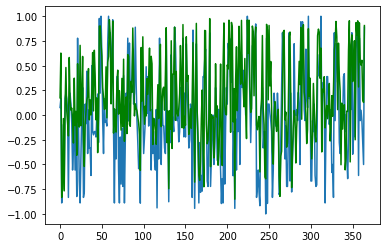

In [1196]:
plt.plot(x,y1)
plt.plot(x,y2,color='green')

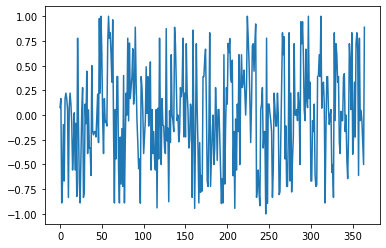

In [1197]:
plt.plot(x,y1)

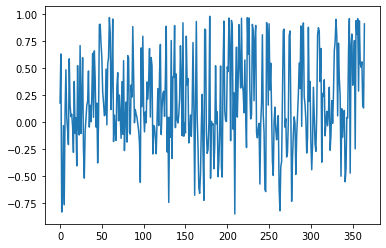

In [1198]:
plt.plot(x,y2)

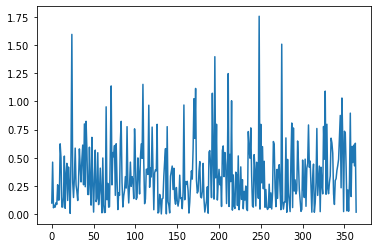

In [1199]:
plt.plot(x,errs)